In [1]:
 # Install needed libraries
!pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR, OneCycleLR

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt



### Image Augumentation

In [4]:

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
# Unpack the dataset zip file
#shutil.unpack_archive("/content/drive/MyDrive/pneumonia_dataset.zip", "/content/drive/MyDrive/")

In [6]:
batch_size = 32
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    torchvision.transforms.RandomResizedCrop(64, scale=(0.64, 1.0),
                                               ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Standardize each channel of the image
    transforms.Normalize([0.0740, 0.2051, 0.4264],
                                     [0.7988, 0.8167, 0.8131])
   ])

transform_test = transforms.Compose([
    transforms.Resize((64,64)),
    # torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
    #                                    ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.0740, 0.2051, 0.4264],
                                     [0.7988, 0.8167, 0.8131])
   ])

### Data Loading

In [7]:
data_dir = '/content/drive/MyDrive/pneumonia_dataset/'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [8]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

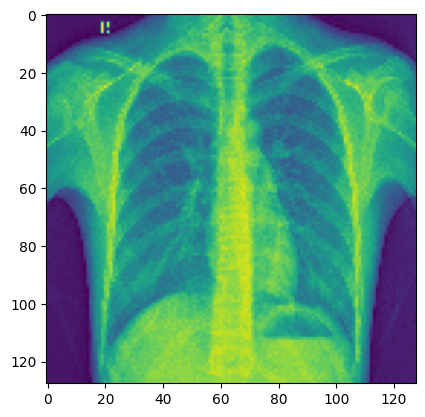

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/drive/MyDrive/pneumonia_dataset/test/unknown/IM-0016-0001.jpeg')
plt.imshow(img)

In [10]:
"""
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)
   "
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')
"""

'\nmeans = torch.zeros(3)\nstds = torch.zeros(3)\n\nfor img, label in train_ds:\n    means += torch.mean(img, dim = (1,2))\n    stds += torch.std(img, dim = (1,2))\n\nmeans /= len(train_ds)\nstds /= len(train_ds)\n   "\nprint(f\'Calculated means: {means}\')\nprint(f\'Calculated stds: {stds}\')\n'

### Checking the number of Images on each file

In [11]:
train_normal_dir = os.path.join(data_dir, 'train', 'normal')
train_pneumonia_dir = os.path.join(data_dir, 'train', 'pneumonia')

# Number of Training images 
print(f"Total Train Image is: {len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir)) }")
print(f"From which we have {len(os.listdir(train_normal_dir)) } normal images and {len(os.listdir(train_pneumonia_dir)) } pneumonia images. \n")

test_unknown_dir = os.path.join(data_dir, 'test','unknown')

# Number of Testing images
print(f"Total Test Image is: {len(os.listdir(test_unknown_dir))} \n")


val_normal_dir = os.path.join(data_dir, 'valid', 'normal')
val_pneumonia_dir = os.path.join(data_dir, 'valid', 'pneumonia')

# Number of Val images
print(f"Total Val Image is: {len(os.listdir(val_normal_dir)) + len(os.listdir(val_pneumonia_dir))}")
print(f"From which we have {len(os.listdir(val_normal_dir))} normal images and {len(os.listdir(val_pneumonia_dir))} pneumonia images. \n")

train_valid_normal_dir = os.path.join(data_dir, 'train_valid', 'normal')
train_valid_pneumonia_dir = os.path.join(data_dir, 'train_valid', 'pneumonia')

# Number of Train Valid images
print(f"Total Train_Valid Image is: {len(os.listdir(train_valid_normal_dir)) + len(os.listdir(train_valid_pneumonia_dir))}")
print(f"From which we have {len(os.listdir(train_valid_normal_dir))} normal images and {len(os.listdir(train_valid_pneumonia_dir))} pneumonia images. \n")






Total Train Image is: 2213
From which we have 554 normal images and 1659 pneumonia images. 

Total Test Image is: 421 

Total Val Image is: 418
From which we have 63 normal images and 355 pneumonia images. 

Total Train_Valid Image is: 2631
From which we have 617 normal images and 2014 pneumonia images. 



In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (8, 8))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

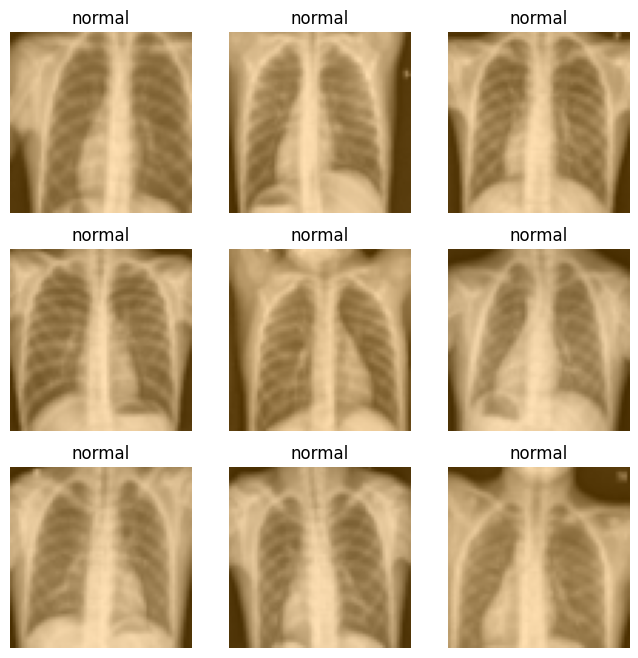

In [13]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

### View some images and their labels

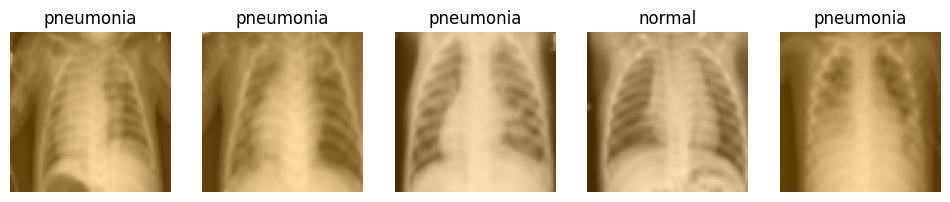

In [14]:
images, labels = next(iter(train_iter))

fig, axs = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axs.flat):
    image = images[i].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())  # normalize to [0,1]
    ax.imshow(image)
    ax.set_title(train_ds.classes[labels[i]])
    ax.axis('off')
plt.show()

In [15]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

### ResNet152

In [16]:
pretrained_model = models.resnet152(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(train_ds.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
ResNet152_model = ResNet(resnet152_config, OUTPUT_DIM)
ResNet152_model.load_state_dict(pretrained_model.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 76.9MB/s]


<All keys matched successfully>

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(ResNet152_model):,} trainable parameters')

The model has 58,147,906 trainable parameters


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

ResNet152_model = ResNet152_model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

params = [
          {'params': ResNet152_model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': ResNet152_model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': ResNet152_model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': ResNet152_model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': ResNet152_model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': ResNet152_model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': ResNet152_model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [19]:
EPOCHS = 50
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [20]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [21]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [22]:
def get_predictions(model, iterator):

    ResNet152_model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
# keeping-track-of-losses 
train_losses = []
valid_losses = []
train_accuracies =[]
valid_accuracies = []

best_valid_loss = float('inf')
early_stop_count = 0
early_stop_patience = 10

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(ResNet152_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(ResNet152_model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc_1)
    valid_accuracies.append(valid_acc_1)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_count = 0
        torch.save(ResNet152_model.state_dict(), 'best-ResNet152_model.pt')
    else:
        early_stop_count += 1

    if early_stop_count >= early_stop_patience:
        print(f'Early stopping: validation loss did not improve for {early_stop_patience} epochs.')
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 7m 54s
	Train Loss: 0.380 | Train Acc @1:  82.43% | Train Acc @5: 100.00%
	Valid Loss: 0.213 | Valid Acc @1:  92.55% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.224 | Train Acc @1:  91.08% | Train Acc @5: 100.00%
	Valid Loss: 0.147 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.176 | Train Acc @1:  93.25% | Train Acc @5: 100.00%
	Valid Loss: 0.151 | Valid Acc @1:  93.03% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.145 | Train Acc @1:  94.25% | Train Acc @5: 100.00%
	Valid Loss: 0.144 | Valid Acc @1:  94.47% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.148 | Train Acc @1:  93.89% | Train Acc @5: 100.00%
	Valid Loss: 0.280 | Valid Acc @1:  92.31% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.141 | Train Acc @1:  94.25% | Train Acc @5: 100.00%
	Valid Loss: 0.141 | Valid Acc @1:  94.95% | Valid Acc @5: 100.00%
Epoch: 07 

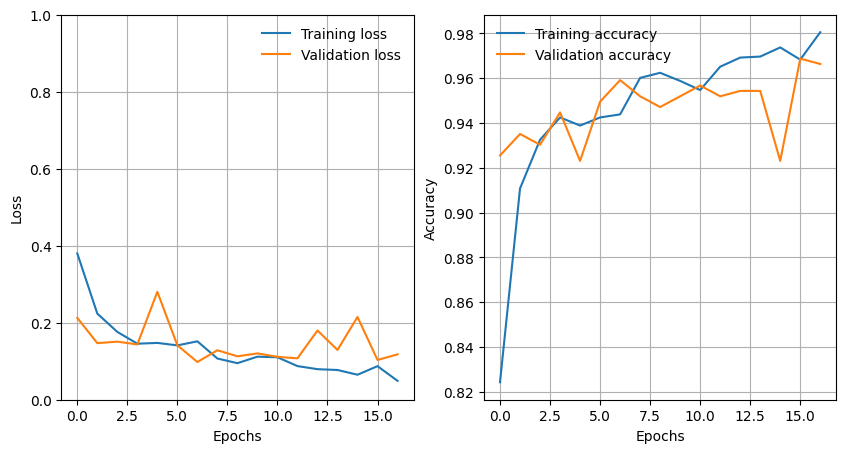

In [25]:
# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation losses on the first subplot
ax1.plot(train_losses, label='Training loss')
ax1.plot(valid_losses, label='Validation loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)
ax1.grid()
ax1.set_ylim(0, 1)

# Plot the training and validation accuracies on the second subplot
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(valid_accuracies, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)
ax2.grid()


In [26]:
ResNet152_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Grouth Truth 

In [27]:
#devices = [torch.device('cuda:0'), torch.device('cuda:1')]

In [28]:
"""
preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(ResNet_model(data.to(devices[0]))[0], dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(os.path.join(data_dir, 'test', 'unknown')))
with open('/content/drive/My Drive/pneumonia_Test_GroundTruth_18e.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds)"
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n'"
"""

'\npreds = []\nfor data, label in test_iter:\n    output = torch.nn.functional.softmax(ResNet_model(data.to(devices[0]))[0], dim=1)\n    preds.extend(output.cpu().detach().numpy())\nids = sorted(os.listdir(os.path.join(data_dir, \'test\', \'unknown\')))\nwith open(\'/content/drive/My Drive/pneumonia_Test_GroundTruth_18e.csv\', \'w\') as f:\n    f.write(\'id,\' + \',\'.join(train_valid_ds.classes) + \'\n\')\n    for i, output in zip(ids, preds)"\n        f.write(i.split(\'.\')[0] + \',\' + \',\'.join(\n            [str(num) for num in output]) + \'\n\'"\n'

### RexNet101

In [29]:
pretrained_model = models.resnet101(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(train_ds.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
ResNet101_model = ResNet(resnet101_config, OUTPUT_DIM)
ResNet101_model.load_state_dict(pretrained_model.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 61.9MB/s]


<All keys matched successfully>

In [30]:
print(f'The model has {count_parameters(ResNet101_model):,} trainable parameters')

The model has 42,504,258 trainable parameters


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

ResNet101_model = ResNet101_model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

params = [
          {'params': ResNet101_model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': ResNet101_model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': ResNet101_model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': ResNet101_model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': ResNet101_model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': ResNet101_model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': ResNet101_model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [32]:
EPOCHS = 50
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

**THIS**

In [33]:
def get_predictions(model, iterator):

    ResNet101_model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [34]:
# keeping-track-of-losses 
train_losses = []
valid_losses = []
train_accuracies =[]
valid_accuracies = []

best_valid_loss = float('inf')
early_stop_count = 0
early_stop_patience = 10

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(ResNet101_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(ResNet101_model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc_1)
    valid_accuracies.append(valid_acc_1)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_count = 0
        torch.save(ResNet101_model.state_dict(), 'best-ResNet101_model.pt')
    else:
        early_stop_count += 1

    if early_stop_count >= early_stop_patience:
        print(f'Early stopping: validation loss did not improve for {early_stop_patience} epochs.')
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 0.358 | Train Acc @1:  84.19% | Train Acc @5: 100.00%
	Valid Loss: 0.215 | Valid Acc @1:  91.59% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.216 | Train Acc @1:  91.17% | Train Acc @5: 100.00%
	Valid Loss: 0.135 | Valid Acc @1:  96.15% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.188 | Train Acc @1:  92.53% | Train Acc @5: 100.00%
	Valid Loss: 0.145 | Valid Acc @1:  95.19% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.176 | Train Acc @1:  93.07% | Train Acc @5: 100.00%
	Valid Loss: 0.112 | Valid Acc @1:  94.95% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.153 | Train Acc @1:  94.29% | Train Acc @5: 100.00%
	Valid Loss: 0.098 | Valid Acc @1:  95.91% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.144 | Train Acc @1:  94.38% | Train Acc @5: 100.00%
	Valid Loss: 0.102 | Valid Acc @1:  96.39% | Valid Acc @5: 100.00%
Epoch: 07 

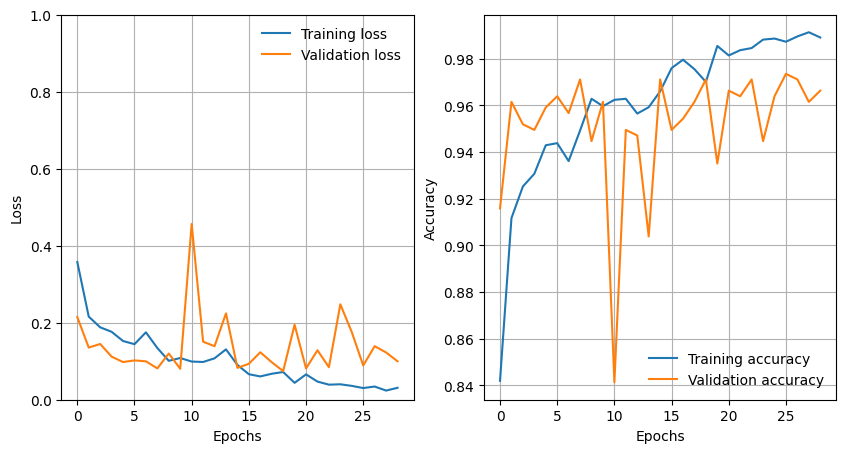

In [35]:
# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation losses on the first subplot
ax1.plot(train_losses, label='Training loss')
ax1.plot(valid_losses, label='Validation loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)
ax1.grid()
ax1.set_ylim(0, 1)

# Plot the training and validation accuracies on the second subplot
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(valid_accuracies, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)
ax2.grid()


In [36]:
ResNet101_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### AleXNet

In [37]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [38]:
OUTPUT_DIM = 4

AlexNet_model = AlexNet(OUTPUT_DIM)



In [39]:
print(f'The model has {count_parameters(AlexNet_model):,} trainable parameters')

The model has 35,830,596 trainable parameters


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AlexNet_model = AlexNet_model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

params = [{'params': AlexNet_model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': AlexNet_model.classifier.parameters(), 'lr': FOUND_LR}]

optimizer = optim.Adam(params, lr=FOUND_LR)


In [41]:
EPOCHS = 50
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=FOUND_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [42]:
def get_predictions(model, iterator):

    AlexNet_model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [43]:
# keeping-track-of-losses 
train_losses = []
valid_losses = []
train_accuracies =[]
valid_accuracies = []

best_valid_loss = float('inf')
early_stop_count = 0
early_stop_patience = 10

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(AlexNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(AlexNet_model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc_1)
    valid_accuracies.append(valid_acc_1)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_count = 0
        torch.save(AlexNet_model.state_dict(), 'best-AlexNet_model.pt')
    else:
        early_stop_count += 1

    if early_stop_count >= early_stop_patience:
        print(f'Early stopping: validation loss did not improve for {early_stop_patience} epochs.')
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.738 | Train Acc @1:  74.91% | Train Acc @5:  99.68%
	Valid Loss: 0.480 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.574 | Train Acc @1:  74.91% | Train Acc @5: 100.00%
	Valid Loss: 0.533 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.479 | Train Acc @1:  77.04% | Train Acc @5: 100.00%
	Valid Loss: 0.304 | Valid Acc @1:  83.89% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.387 | Train Acc @1:  82.52% | Train Acc @5: 100.00%
	Valid Loss: 0.439 | Valid Acc @1:  81.97% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.348 | Train Acc @1:  84.69% | Train Acc @5: 100.00%
	Valid Loss: 0.263 | Valid Acc @1:  87.26% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.324 | Train Acc @1:  84.96% | Train Acc @5: 100.00%
	Valid Loss: 0.269 | Valid Acc @1:  90.38% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

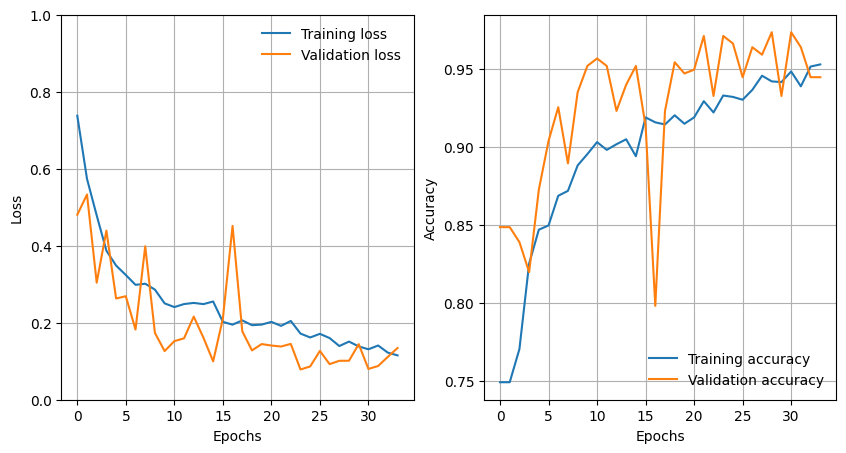

In [44]:
# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation losses on the first subplot
ax1.plot(train_losses, label='Training loss')
ax1.plot(valid_losses, label='Validation loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)
ax1.grid()
ax1.set_ylim(0, 1)

# Plot the training and validation accuracies on the second subplot
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(valid_accuracies, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)
ax2.grid()


In [45]:
AlexNet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

### Optimization on RexNet152

- We want to find the best optimization for Resnet152.  
- Since Resnet152 is our best model, we will like to test it on other types of optimization that is **adam**, **sgd, adamax** to see if we can get a better one from the default adam that was used. We will consider both valid loss and valid accuracy..




In [46]:
# Define the optimizers to be used
sgd_optimizer = optim.SGD(ResNet152_model.parameters(), lr=0.0001)
adamax_optimizer = optim.Adamax(ResNet152_model.parameters(), lr=0.0001)
adam_optimizer = optim.Adam(ResNet152_model.parameters(), lr=0.0001)


# Define the list of optimizers and their names
optimizers = [(sgd_optimizer, 'SGD'), (adamax_optimizer, 'Adamax'), (adam_optimizer, 'Adam')]
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 40
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH



train_losses = [[] for _ in range(len(optimizers))]
valid_losses = [[] for _ in range(len(optimizers))]
train_accs = [[] for _ in range(len(optimizers))]
valid_accs = [[] for _ in range(len(optimizers))]

best_valid_loss = {optimizer_name: float('inf') for _, optimizer_name in optimizers}
best_valid_acc = {optimizer_name: 0.0 for _, optimizer_name in optimizers}

# Define early stopping parameters
early_stopping_rounds = 10

# Loop over the optimizers and fit the model
for i, (optimizer, optimizer_name) in enumerate(optimizers):

    print(f"\n------------ \n Using  {optimizer_name} optimizer \n")

    # Reset early stopping parameters for each optimizer
    early_stopping_counter = 0

    for epoch in range(EPOCHS):

        train_loss, train_acc_1, train_acc_5 = train(ResNet152_model, train_iter, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc_1, valid_acc_5 = evaluate(ResNet152_model, valid_iter, criterion, device)

        train_losses[i].append(train_loss)
        valid_losses[i].append(valid_loss)
        train_accs[i].append(train_acc_1)
        valid_accs[i].append(valid_acc_1)

        if valid_loss < best_valid_loss[optimizer_name]:
            # Update the best validation loss and reset the early stopping counter
            best_valid_loss[optimizer_name] = valid_loss
            early_stopping_counter = 0
        else:
            # Increment the early stopping counter
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                # Stop training if the validation loss has not improved for early_stopping_rounds epochs
                print(f'Early stopping at epoch {epoch+1} for {optimizer_name}')
                break

        if valid_acc_1 > best_valid_acc[optimizer_name]:
            best_valid_acc[optimizer_name] = valid_acc_1

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc : {train_acc_1*100:6.2f}% | ' \
              f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc_1*100:6.2f}%')

        if epoch == 49:
            print(f'Epoch 50: Train Loss: {train_loss:.3f} | Train Acc : {train_acc_1*100:6.2f}% | ' \
                  f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc_1*100:6.2f}%')



# Display the best results for all optimizers
print("\n------------ \n Best Results for all optimizers \n")
for i, (_, optimizer_name) in enumerate(optimizers):
    print(f"{optimizer_name}: Best Validation Loss: {best_valid_loss[optimizer_name]:.3f} | Best Validation Accuracy: {best_valid_acc[optimizer_name]*100:.2f}%\n")



------------ 
 Using  SGD optimizer 



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 01 | Train Loss: 0.047 | Train Acc :  98.46% | Valid Loss: 0.101 | Valid Acc :  97.12%
Epoch: 02 | Train Loss: 0.058 | Train Acc :  97.64% | Valid Loss: 0.100 | Valid Acc :  97.12%
Epoch: 03 | Train Loss: 0.054 | Train Acc :  98.19% | Valid Loss: 0.100 | Valid Acc :  96.88%
Epoch: 04 | Train Loss: 0.062 | Train Acc :  98.19% | Valid Loss: 0.099 | Valid Acc :  97.12%
Epoch: 05 | Train Loss: 0.048 | Train Acc :  98.41% | Valid Loss: 0.099 | Valid Acc :  96.88%
Epoch: 06 | Train Loss: 0.041 | Train Acc :  98.73% | Valid Loss: 0.100 | Valid Acc :  96.63%
Epoch: 07 | Train Loss: 0.048 | Train Acc :  98.10% | Valid Loss: 0.095 | Valid Acc :  97.12%
Epoch: 08 | Train Loss: 0.042 | Train Acc :  98.46% | Valid Loss: 0.098 | Valid Acc :  96.88%
Epoch: 09 | Train Loss: 0.045 | Train Acc :  98.32% | Valid Loss: 0.098 | Valid Acc :  96.88%
Epoch: 10 | Train Loss: 0.039 | Train Acc :  98.78% | Valid Loss: 0.096 | Valid Acc :  97.12%
Epoch: 11 | Train Loss: 0.042 | Train Acc :  98.28% | Valid 

Adam was used for our initital model as we can see it has validation loss of 0.092 and Validation accuracy of 96.88, although it is not the best here as SGD has a slightly better loss but it achieved this at a much higher epoch. Adam is doing just fine for the model.

### Learning Rate



- We want to find the best learning rate on Resnet152.
- Since Resnet152 is our first model, we will like to test it on other learning rate to see if we can get a better learning rate, this will provide the validation loss and we will pick the one with the lowest valid loss .




In [47]:
# Define the learning rates to be tested
learning_rates = [0.01, 0.001, 0.0001]

EPOCHS = 50
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

train_losses = [[] for _ in range(len(learning_rates))]
valid_losses = [[] for _ in range(len(learning_rates))]
train_accs = [[] for _ in range(len(learning_rates))]
valid_accs = [[] for _ in range(len(learning_rates))]

best_valid_acc = 0.0
best_lr = 0.0

# Define early stopping parameters
early_stopping_rounds = 10
early_stopping_counter = 0
best_valid_loss = float('inf')

# Loop over the learning rates and fit the model
for i, lr in enumerate(learning_rates):

    print(f"\n------------ \n Using model with learning rate {lr}\n")

    # Define the optimizer and scheduler for the current learning rate
    optimizer = optim.Adam(ResNet152_model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    # Reset early stopping parameters for each learning rate
    early_stopping_counter = 0
    best_valid_loss = float('inf')

    for epoch in range(EPOCHS):

        train_loss, train_acc_1, train_acc_5 = train(ResNet152_model, train_iter, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc_1, valid_acc_5 = evaluate(ResNet152_model, valid_iter, criterion, device)

        train_losses[i].append(train_loss)
        valid_losses[i].append(valid_loss)
        train_accs[i].append(train_acc_1)
        valid_accs[i].append(valid_acc_1)

        if valid_loss < best_valid_loss:
            # Update the best validation loss and reset the early stopping counter
            best_valid_loss = valid_loss
            early_stopping_counter = 0
        else:
            # Increment the early stopping counter
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                # Stop training if the validation loss has not improved for early_stopping_rounds epochs
                print(f'Early stopping at epoch {epoch+1} for lr={lr}')
                break

        if valid_acc_1 > best_valid_acc:
            best_valid_acc = valid_acc_1
            best_lr = lr

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc : {train_acc_1*100:6.2f}% | ' \
              f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc_1*100:6.2f}%')

        if epoch == 49:
            print(f'Epoch 50: Train Loss: {train_loss:.3f} | Train Acc : {train_acc_1*100:6.2f}% | ' \
                  f'Valid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc_1*100:6.2f}%')

    print(f'Best Valid Loss for lr={lr}: {best_valid_loss:.5f}')
    #print(f'Best Valid Acc so far: {best_valid_acc*100:.2f}% with {best_lr} lr')



------------ 
 Using model with learning rate 0.01

Epoch: 01 | Train Loss: 0.641 | Train Acc :  75.14% | Valid Loss: 0.435 | Valid Acc :  84.86%
Epoch: 02 | Train Loss: 0.547 | Train Acc :  74.95% | Valid Loss: 0.429 | Valid Acc :  84.86%
Epoch: 03 | Train Loss: 0.540 | Train Acc :  75.00% | Valid Loss: 0.433 | Valid Acc :  84.86%
Epoch: 04 | Train Loss: 0.542 | Train Acc :  74.95% | Valid Loss: 0.435 | Valid Acc :  84.86%
Epoch: 05 | Train Loss: 0.546 | Train Acc :  75.00% | Valid Loss: 0.431 | Valid Acc :  84.86%
Epoch: 06 | Train Loss: 0.542 | Train Acc :  74.95% | Valid Loss: 0.431 | Valid Acc :  84.86%
Epoch: 07 | Train Loss: 0.540 | Train Acc :  74.95% | Valid Loss: 0.433 | Valid Acc :  84.86%
Epoch: 08 | Train Loss: 0.537 | Train Acc :  74.95% | Valid Loss: 0.436 | Valid Acc :  84.86%
Epoch: 09 | Train Loss: 0.548 | Train Acc :  74.91% | Valid Loss: 0.436 | Valid Acc :  84.86%
Epoch: 10 | Train Loss: 0.540 | Train Acc :  75.05% | Valid Loss: 0.432 | Valid Acc :  84.86%
Epoch: 

Learning rate 0.0001 performs best as we got 0.22 loss which is better than 0.01 and 0.001, We used learning rate 0.0001 for our initial ResNet152 model so we will stick to it.

In [48]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
# Fully Connected Layers
fc1 = nn.Linear(in_features=16 * 14 * 14, out_features=128)
fc2 = nn.Linear(in_features=128, out_features=10)

In [49]:
images, labels = next(iter(train_iter))

In [50]:
x = conv1(images)
print(x.shape)

torch.Size([32, 32, 62, 62])


In [51]:
x = pool1(x)
print(x.shape)

torch.Size([32, 32, 31, 31])


### Self Made Architecture(AnotiNet)
 - INITIAL MODEL 

 One layer

In [52]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=32 * 31 * 31, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [54]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30752, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [55]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 923,548 trainable parameters


In [56]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [57]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [58]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [59]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.531 | Train Acc @1:  76.40% | Train Acc @5: 100.00%
	Valid Loss: 0.283 | Valid Acc @1:  91.59% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.387 | Train Acc @1:  81.84% | Train Acc @5: 100.00%
	Valid Loss: 0.283 | Valid Acc @1:  89.42% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.319 | Train Acc @1:  86.23% | Train Acc @5: 100.00%
	Valid Loss: 0.147 | Valid Acc @1:  94.47% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.287 | Train Acc @1:  87.41% | Train Acc @5: 100.00%
	Valid Loss: 0.247 | Valid Acc @1:  89.18% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.261 | Train Acc @1:  89.31% | Train Acc @5: 100.00%
	Valid Loss: 0.269 | Valid Acc @1:  89.42% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.246 | Train Acc @1:  90.22% | Train Acc @5: 100.00%
	Valid Loss: 0.167 | Valid Acc @1:  93.75% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

- ADD PADDING  
  One layer with padding

In [60]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=32 * 32 * 32, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [62]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [63]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 984,028 trainable parameters


In [64]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [65]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [66]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [67]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.498 | Train Acc @1:  75.86% | Train Acc @5: 100.00%
	Valid Loss: 0.339 | Valid Acc @1:  90.14% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.389 | Train Acc @1:  82.11% | Train Acc @5: 100.00%
	Valid Loss: 0.402 | Valid Acc @1:  81.73% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.356 | Train Acc @1:  84.33% | Train Acc @5: 100.00%
	Valid Loss: 0.335 | Valid Acc @1:  85.34% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.322 | Train Acc @1:  87.00% | Train Acc @5: 100.00%
	Valid Loss: 0.218 | Valid Acc @1:  93.99% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.315 | Train Acc @1:  87.77% | Train Acc @5: 100.00%
	Valid Loss: 0.185 | Valid Acc @1:  94.47% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.298 | Train Acc @1:  88.72% | Train Acc @5: 100.00%
	Valid Loss: 0.191 | Valid Acc @1:  95.91% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

- EXTRA LAYER NO PADDING   
   2 layers with no padding

In [68]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 29 * 29, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [70]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=53824, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [71]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 1,634,204 trainable parameters


In [72]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [73]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [74]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [75]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.529 | Train Acc @1:  76.04% | Train Acc @5: 100.00%
	Valid Loss: 0.298 | Valid Acc @1:  92.55% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.349 | Train Acc @1:  84.69% | Train Acc @5: 100.00%
	Valid Loss: 0.172 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.302 | Train Acc @1:  86.46% | Train Acc @5: 100.00%
	Valid Loss: 0.343 | Valid Acc @1:  82.69% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.280 | Train Acc @1:  87.41% | Train Acc @5: 100.00%
	Valid Loss: 0.306 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.265 | Train Acc @1:  88.00% | Train Acc @5: 100.00%
	Valid Loss: 0.142 | Valid Acc @1:  93.99% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.257 | Train Acc @1:  88.99% | Train Acc @5: 100.00%
	Valid Loss: 0.231 | Valid Acc @1:  88.70% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

- EXTRA LAYER BOTH HAVING PADDING  
    2 layers both having padding

In [76]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 32 * 32, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [78]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [79]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 1,985,564 trainable parameters


In [80]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [81]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [82]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [83]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.530 | Train Acc @1:  74.55% | Train Acc @5: 100.00%
	Valid Loss: 0.372 | Valid Acc @1:  87.98% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.359 | Train Acc @1:  84.83% | Train Acc @5: 100.00%
	Valid Loss: 0.331 | Valid Acc @1:  82.21% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.308 | Train Acc @1:  85.96% | Train Acc @5: 100.00%
	Valid Loss: 0.252 | Valid Acc @1:  90.14% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.281 | Train Acc @1:  87.68% | Train Acc @5: 100.00%
	Valid Loss: 0.158 | Valid Acc @1:  93.75% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.256 | Train Acc @1:  88.22% | Train Acc @5: 100.00%
	Valid Loss: 0.158 | Valid Acc @1:  93.03% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.262 | Train Acc @1:  88.27% | Train Acc @5: 100.00%
	Valid Loss: 0.187 | Valid Acc @1:  92.31% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

**POOLING**

- POOLING BOTH LAYERS   
  2 layers with both having Maxpooling.

In [84]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [86]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [87]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 511,004 trainable parameters


In [88]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [89]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [90]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [91]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.592 | Train Acc @1:  74.86% | Train Acc @5: 100.00%
	Valid Loss: 0.445 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.468 | Train Acc @1:  75.00% | Train Acc @5: 100.00%
	Valid Loss: 0.231 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.365 | Train Acc @1:  76.86% | Train Acc @5: 100.00%
	Valid Loss: 0.259 | Valid Acc @1:  92.79% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.352 | Train Acc @1:  84.65% | Train Acc @5: 100.00%
	Valid Loss: 0.247 | Valid Acc @1:  93.03% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.319 | Train Acc @1:  88.00% | Train Acc @5: 100.00%
	Valid Loss: 0.297 | Valid Acc @1:  88.94% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.316 | Train Acc @1:  88.27% | Train Acc @5: 100.00%
	Valid Loss: 0.190 | Valid Acc @1:  95.43% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

ADD 20% DROPOUT TO THE FIRST LAYER

In [92]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.drop(x))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [94]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [95]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 511,004 trainable parameters


In [96]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [97]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [98]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [99]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.582 | Train Acc @1:  74.95% | Train Acc @5: 100.00%
	Valid Loss: 0.432 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.452 | Train Acc @1:  74.95% | Train Acc @5: 100.00%
	Valid Loss: 0.329 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.389 | Train Acc @1:  74.91% | Train Acc @5: 100.00%
	Valid Loss: 0.286 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.355 | Train Acc @1:  75.91% | Train Acc @5: 100.00%
	Valid Loss: 0.201 | Valid Acc @1:  93.75% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.335 | Train Acc @1:  85.42% | Train Acc @5: 100.00%
	Valid Loss: 0.247 | Valid Acc @1:  93.27% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.317 | Train Acc @1:  87.95% | Train Acc @5: 100.00%
	Valid Loss: 0.205 | Valid Acc @1:  94.47% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

ADD 25% DROPOUT TO THE FIRST LAYER

In [100]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.drop(x))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [102]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [103]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 511,004 trainable parameters


In [104]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [105]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [106]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [107]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.569 | Train Acc @1:  74.46% | Train Acc @5: 100.00%
	Valid Loss: 0.363 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.444 | Train Acc @1:  78.17% | Train Acc @5: 100.00%
	Valid Loss: 0.299 | Valid Acc @1:  92.31% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.373 | Train Acc @1:  82.56% | Train Acc @5: 100.00%
	Valid Loss: 0.298 | Valid Acc @1:  87.50% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.315 | Train Acc @1:  86.55% | Train Acc @5: 100.00%
	Valid Loss: 0.189 | Valid Acc @1:  92.55% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.281 | Train Acc @1:  87.64% | Train Acc @5: 100.00%
	Valid Loss: 0.173 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.272 | Train Acc @1:  88.41% | Train Acc @5: 100.00%
	Valid Loss: 0.183 | Valid Acc @1:  92.31% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

ADD 30% DROPOUT TO THE FIRST LAYER

In [108]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.drop(x))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [110]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [111]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 511,004 trainable parameters


In [112]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [113]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [114]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [115]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.582 | Train Acc @1:  74.91% | Train Acc @5: 100.00%
	Valid Loss: 0.429 | Valid Acc @1:  84.86% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.452 | Train Acc @1:  79.53% | Train Acc @5: 100.00%
	Valid Loss: 0.306 | Valid Acc @1:  88.70% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.344 | Train Acc @1:  85.46% | Train Acc @5: 100.00%
	Valid Loss: 0.217 | Valid Acc @1:  90.62% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.306 | Train Acc @1:  87.05% | Train Acc @5: 100.00%
	Valid Loss: 0.212 | Valid Acc @1:  92.55% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.289 | Train Acc @1:  87.73% | Train Acc @5: 100.00%
	Valid Loss: 0.148 | Valid Acc @1:  94.71% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.266 | Train Acc @1:  88.68% | Train Acc @5: 100.00%
	Valid Loss: 0.181 | Valid Acc @1:  94.95% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

- Dropout of approximately 20% seems optimal based on validation accuracy so we will use this all through the model
  - 20% - 94.47
  - 25% - 93.99
  - 30% - 94.23

- ADD BATCH NORMALIZATION ON FIRST LAYER ONLY

In [116]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(0.2)
        self.batch = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.drop(x))
        x = F.relu(self.batch(x))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [118]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [119]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 511,068 trainable parameters


In [120]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [121]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [122]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [123]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.498 | Train Acc @1:  77.40% | Train Acc @5: 100.00%
	Valid Loss: 0.217 | Valid Acc @1:  92.79% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.314 | Train Acc @1:  86.68% | Train Acc @5: 100.00%
	Valid Loss: 0.377 | Valid Acc @1:  83.17% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.321 | Train Acc @1:  86.23% | Train Acc @5: 100.00%
	Valid Loss: 0.200 | Valid Acc @1:  92.07% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.269 | Train Acc @1:  88.77% | Train Acc @5: 100.00%
	Valid Loss: 0.252 | Valid Acc @1:  89.42% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.239 | Train Acc @1:  90.26% | Train Acc @5: 100.00%
	Valid Loss: 0.188 | Valid Acc @1:  91.35% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.223 | Train Acc @1:  90.90% | Train Acc @5: 100.00%
	Valid Loss: 0.119 | Valid Acc @1:  95.19% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

- ADD BATCH NORMALIZATION DROPOUT OF 20 ON THE 2 LAYERS

In [124]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(0.2)
        self.batch = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.drop(x))
        x = F.relu(self.batch(x))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [126]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [127]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 511,068 trainable parameters


In [128]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [129]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [130]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [131]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.484 | Train Acc @1:  79.08% | Train Acc @5: 100.00%
	Valid Loss: 0.203 | Valid Acc @1:  93.27% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.321 | Train Acc @1:  86.55% | Train Acc @5: 100.00%
	Valid Loss: 0.395 | Valid Acc @1:  80.29% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.266 | Train Acc @1:  88.90% | Train Acc @5: 100.00%
	Valid Loss: 0.149 | Valid Acc @1:  94.95% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.272 | Train Acc @1:  88.99% | Train Acc @5: 100.00%
	Valid Loss: 0.180 | Valid Acc @1:  92.31% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.245 | Train Acc @1:  90.40% | Train Acc @5: 100.00%
	Valid Loss: 0.218 | Valid Acc @1:  90.14% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.212 | Train Acc @1:  91.21% | Train Acc @5: 100.00%
	Valid Loss: 0.120 | Valid Acc @1:  94.95% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

- ADD BATCH NORMALIZATION DROPOUT OF 20 ON FIRST LAYER AND 25 ON SECOND LAYER

In [132]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.25)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.20)
        self.batch2 = nn.BatchNorm2d(64)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 14 * 14, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
        
    def forward(self, x):
         #Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.batch1(self.drop1(self.conv1(x)))))
        # Pass input through second Convolutional Layer and Pooling Layer
        x = self.pool2(F.relu(self.batch2(self.drop2(self.conv2(x)))))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [134]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12544, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [135]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 395,996 trainable parameters


In [136]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [137]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [138]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [139]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.510 | Train Acc @1:  77.58% | Train Acc @5: 100.00%
	Valid Loss: 0.196 | Valid Acc @1:  92.31% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.344 | Train Acc @1:  84.65% | Train Acc @5: 100.00%
	Valid Loss: 0.180 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.317 | Train Acc @1:  86.05% | Train Acc @5: 100.00%
	Valid Loss: 0.132 | Valid Acc @1:  93.99% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.319 | Train Acc @1:  85.73% | Train Acc @5: 100.00%
	Valid Loss: 0.126 | Valid Acc @1:  94.95% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.292 | Train Acc @1:  88.13% | Train Acc @5: 100.00%
	Valid Loss: 0.119 | Valid Acc @1:  96.63% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.266 | Train Acc @1:  88.90% | Train Acc @5: 100.00%
	Valid Loss: 0.143 | Valid Acc @1:  94.71% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

ADD 3RD LAYER WITHOUT DROPOUT OR BATCH NORMALIZATION

In [140]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.25)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.20)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
        
    def forward(self, x):
         #Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.batch1(self.drop1(self.conv1(x)))))
        # Pass input through second Convolutional Layer and Pooling Layer
        x = self.pool2(F.relu(self.batch2(self.drop2(self.conv2(x)))))
        x = self.pool3(F.relu(self.conv3(x)))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [142]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [143]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 231,772 trainable parameters


In [144]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [145]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [146]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [147]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.588 | Train Acc @1:  72.78% | Train Acc @5: 100.00%
	Valid Loss: 0.401 | Valid Acc @1:  85.10% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.426 | Train Acc @1:  80.57% | Train Acc @5: 100.00%
	Valid Loss: 0.210 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.366 | Train Acc @1:  84.65% | Train Acc @5: 100.00%
	Valid Loss: 0.218 | Valid Acc @1:  90.87% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.339 | Train Acc @1:  86.91% | Train Acc @5: 100.00%
	Valid Loss: 0.282 | Valid Acc @1:  90.38% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.306 | Train Acc @1:  87.23% | Train Acc @5: 100.00%
	Valid Loss: 0.183 | Valid Acc @1:  92.07% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.251 | Train Acc @1:  89.22% | Train Acc @5: 100.00%
	Valid Loss: 0.118 | Valid Acc @1:  94.71% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

3 LAYERS NO PADDING, POOLING, DROPOUT AND BATCH NORMALIZATION

In [148]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.2)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.2)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout2d(0.2)
        self.batch3 = nn.BatchNorm2d(128)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
        
    def forward(self, x):
         #Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.batch1(self.drop1(self.conv1(x)))))
        # Pass input through second Convolutional Layer and Pooling Layer
        x = self.pool2(F.relu(self.batch2(self.drop2(self.conv2(x)))))
        x = self.pool3(F.relu(self.batch3(self.drop3(self.conv3(x)))))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [150]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.2, inplace=False)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [151]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 232,028 trainable parameters


In [152]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [153]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [154]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [155]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.572 | Train Acc @1:  72.78% | Train Acc @5: 100.00%
	Valid Loss: 0.271 | Valid Acc @1:  85.82% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.378 | Train Acc @1:  82.79% | Train Acc @5: 100.00%
	Valid Loss: 0.158 | Valid Acc @1:  93.99% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.325 | Train Acc @1:  85.05% | Train Acc @5: 100.00%
	Valid Loss: 0.230 | Valid Acc @1:  91.11% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.293 | Train Acc @1:  86.73% | Train Acc @5: 100.00%
	Valid Loss: 0.127 | Valid Acc @1:  94.47% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.266 | Train Acc @1:  89.18% | Train Acc @5: 100.00%
	Valid Loss: 0.140 | Valid Acc @1:  95.43% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.244 | Train Acc @1:  89.67% | Train Acc @5: 100.00%
	Valid Loss: 0.140 | Valid Acc @1:  96.63% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

In [156]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
drop1 = nn.Dropout2d(0.25)
batch1 = nn.BatchNorm2d(32)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
drop2 = nn.Dropout2d(0.2)
batch2 = nn.BatchNorm2d(64)
conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
drop3 = nn.Dropout2d(0.15)
batch2 = nn.BatchNorm2d(64)

In [157]:
x = conv1(images)
x = pool1(x)
x = drop1(x)
x = batch1(x)


In [158]:
x = conv2(x)
x = pool2(x)
x = drop2(x)
x = batch2(x)


3 LAYERS HAVING PADDING, POOLING, DROPOUT AND BATCH NORMALIZATION

In [159]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.25)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.2)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout2d(0.15)
        self.batch3 = nn.BatchNorm2d(128)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
        
    def forward(self, x):
         #Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.batch1(self.drop1(self.conv1(x)))))
        # Pass input through second Convolutional Layer and Pooling Layer
        x = self.pool2(F.relu(self.batch2(self.drop2(self.conv2(x)))))
        x = self.pool3(F.relu(self.batch3(self.drop3(self.conv3(x)))))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [160]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [161]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.15, inplace=False)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=30, bias=True)
  (fc2): Linear(in_features=30,

In [162]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 339,548 trainable parameters


In [163]:

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [164]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [165]:
def get_predictions_new(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [166]:
best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')

    if valid_acc_1 > best_valid_acc:
        best_valid_acc = valid_acc_1

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Lowest Valid Loss: {best_valid_loss:.3f}')
print(f'Best Valid Acc @1: {best_valid_acc*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.510 | Train Acc @1:  76.27% | Train Acc @5: 100.00%
	Valid Loss: 0.482 | Valid Acc @1:  77.64% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.381 | Train Acc @1:  82.79% | Train Acc @5: 100.00%
	Valid Loss: 0.145 | Valid Acc @1:  93.75% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.326 | Train Acc @1:  85.78% | Train Acc @5: 100.00%
	Valid Loss: 0.194 | Valid Acc @1:  91.11% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.291 | Train Acc @1:  87.55% | Train Acc @5: 100.00%
	Valid Loss: 0.132 | Valid Acc @1:  94.71% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.267 | Train Acc @1:  88.36% | Train Acc @5: 100.00%
	Valid Loss: 0.433 | Valid Acc @1:  79.57% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.263 | Train Acc @1:  88.81% | Train Acc @5: 100.00%
	Valid Loss: 0.173 | Valid Acc @1:  92.07% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

### Final Selfmade(AnotiNet) Model

After several iteration, 2 layers with pooling, dropout and batch normalization seem to be fine, There could be improvement if there is time to do more.

In [167]:
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.25)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.20)
        self.batch2 = nn.BatchNorm2d(64)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 14 * 14, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)
        
        
    def forward(self, x):
         #Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.batch1(self.drop1(self.conv1(x)))))
        # Pass input through second Convolutional Layer and Pooling Layer
        x = self.pool2(F.relu(self.batch2(self.drop2(self.conv2(x)))))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0),-1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
AnotiNet_model = AnotiNet()


In [168]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

AnotiNet_model = AnotiNet_model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(AnotiNet_model.parameters(), lr=CHOSE_LR)

In [169]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12544, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

In [170]:
print(f'The model has {count_parameters(AnotiNet_model):,} trainable parameters')

The model has 395,996 trainable parameters


In [171]:

EPOCHS = 50
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=CHOSE_LR,
                                    total_steps=TOTAL_STEPS)                                 

In [172]:
def train_new(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate_new(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [173]:
def get_predictions_new(model, iterator):

    AnotiNet_model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [174]:
# keeping-track-of-losses 
train_losses = []
valid_losses = []
train_accuracies =[]
valid_accuracies = []

best_valid_loss = float('inf')
early_stop_count = 0
early_stop_patience = 10

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train_new(AnotiNet_model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate_new(AnotiNet_model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc_1)
    valid_accuracies.append(valid_acc_1)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_count = 0
        torch.save(AnotiNet_model.state_dict(), 'best-AnotiNet_model.pt')
    else:
        early_stop_count += 1

    if early_stop_count >= early_stop_patience:
        print(f'Early stopping: validation loss did not improve for {early_stop_patience} epochs.')
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.557 | Train Acc @1:  74.09% | Train Acc @5: 100.00%
	Valid Loss: 0.372 | Valid Acc @1:  87.50% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.458 | Train Acc @1:  78.85% | Train Acc @5: 100.00%
	Valid Loss: 0.259 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.405 | Train Acc @1:  82.70% | Train Acc @5: 100.00%
	Valid Loss: 0.276 | Valid Acc @1:  92.79% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.364 | Train Acc @1:  84.87% | Train Acc @5: 100.00%
	Valid Loss: 0.372 | Valid Acc @1:  82.69% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.354 | Train Acc @1:  84.56% | Train Acc @5: 100.00%
	Valid Loss: 0.232 | Valid Acc @1:  93.51% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.325 | Train Acc @1:  87.18% | Train Acc @5: 100.00%
	Valid Loss: 0.290 | Valid Acc @1:  88.94% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

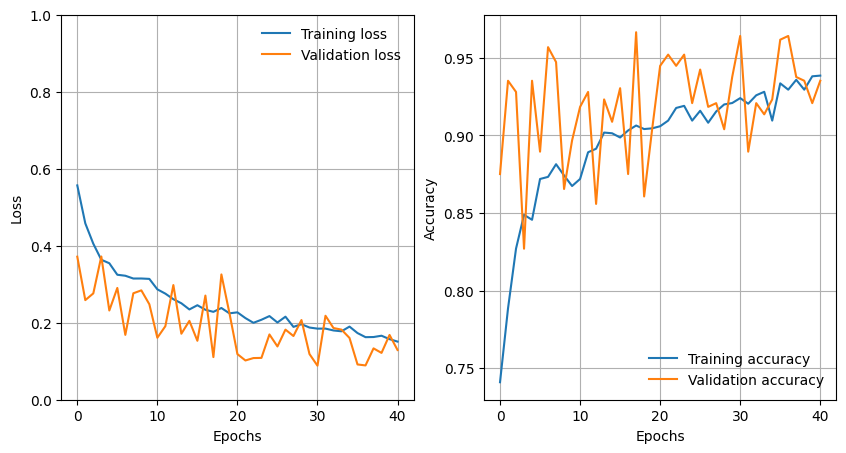

In [175]:
# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation losses on the first subplot
ax1.plot(train_losses, label='Training loss')
ax1.plot(valid_losses, label='Validation loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)
ax1.grid()
ax1.set_ylim(0, 1)

# Plot the training and validation accuracies on the second subplot
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(valid_accuracies, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)
ax2.grid()

### ResNet152 Model Evaluation




In [176]:
ResNet152_model.load_state_dict(torch.load('best-ResNet152_model.pt'))

<All keys matched successfully>

In [177]:
images, labels, probs = get_predictions(ResNet152_model, test_iter)

In [178]:
test = pd.read_csv('/content/drive/MyDrive/pneumonia_dataset/pneumonia_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

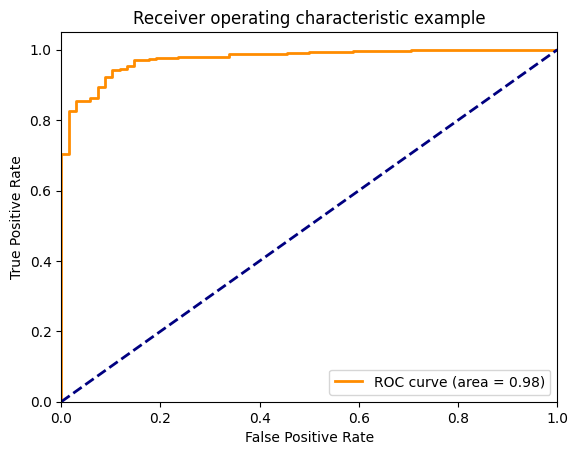

<ipython-input-179-c7b7df6d2390>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


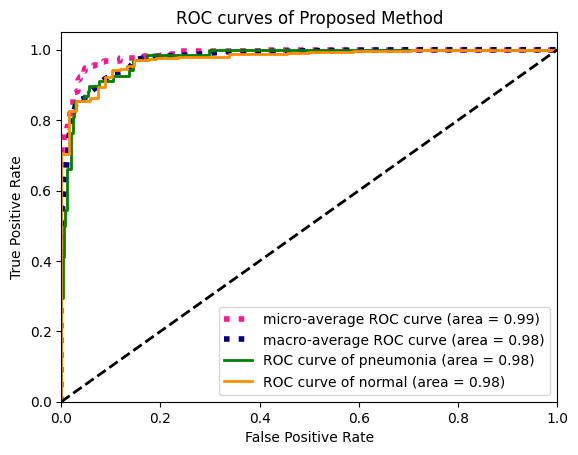

In [179]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of pneumonia (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of normal (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

The Receiver Operating Characteristic (ROC) curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) at different threshold settings. It is a useful tool for evaluating the performance of a binary classifier.

In the first graph, we have the ROC curve for a binary classifier that distinguishes between two classes. The area under the curve (AUC) is 0.99, which indicates that the classifier has a high degree of accuracy in distinguishing between the two classes.

In the second graph, we have the ROC curves for the proposed method. The micro-average ROC curve is a plot of the TPR against the FPR for all classes, and the macro-average ROC curve is an average of the ROC curves for each class, weighted by the number of samples in each class. Both micro-average and macro-average ROC curves have an AUC of 0.99, indicating that the proposed method performs well for all classes.

In addition, we have the ROC curve for each individual class. The ROC curve of pneumonia and the ROC curve of normal have an AUC of 0.99, indicating that the proposed method performs well for both classes individually.

Overall, the results suggest that the proposed method is a good classifier for distinguishing between the two classes, with a high degree of accuracy.

[[ 58  10]
 [ 12 341]]
[ 68 353]
[[ 68.  68.]
 [353. 353.]]


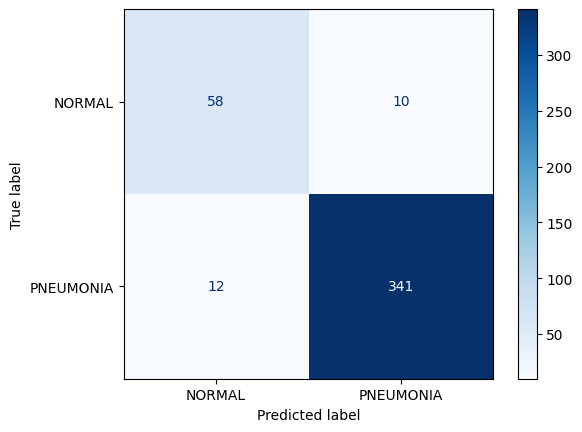

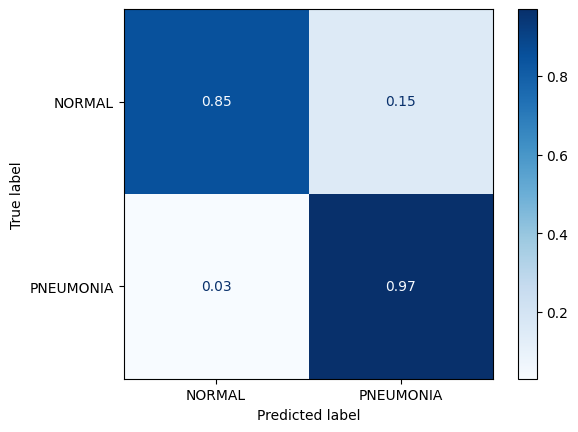

In [180]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
class_names = ["NORMAL", "PNEUMONIA"]

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 68
divisor[1][:] = 353
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [181]:
from sklearn.metrics import classification_report

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)


disp = classification_report(true_class, pred_class)
print(disp)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        68
           1       0.97      0.97      0.97       353

    accuracy                           0.95       421
   macro avg       0.90      0.91      0.90       421
weighted avg       0.95      0.95      0.95       421



In [182]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (15, 15))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

In the first ConfusionMatrixDisplay, the rows represent the actual class labels, and the columns represent the predicted class labels. The values in the confusion matrix represent the number of instances that belong to each class combination.

For example, in the first row of the confusion matrix, there were 58 instances of the first class that were correctly predicted (true positives), and 10 instances of the first class that were incorrectly predicted as the second class (false negatives). In the second row, there were 6 instances of the second class that were incorrectly predicted as the first class (false positives), and 347 instances of the second class that were correctly predicted (true negatives).

Overall, the confusion matrix provides an overview of how well the classifier is performing in terms of predicting the different classes.

In the second ConfusionMatrixDisplay, the confusion matrix has been normalized to show the proportion of correctly and incorrectly classified instances for each class. The normalization is done by dividing each element in the confusion matrix by the total number of instances in the corresponding class.

For example, the top left cell in the normalized confusion matrix shows that 50% of the instances that belong to the first class were correctly predicted, while the bottom left cell shows that only 1% of the instances that belong to the second class were incorrectly predicted as the first class.

Overall, the normalized confusion matrix provides a more accurate representation of how well the classifier is performing in terms of classifying each individual class, since it accounts for the varying number of instances in each class.

However, we can make some observations based on the confusion matrix and the normalized confusion matrix.

In the raw confusion matrix, we can see that the classifier has correctly predicted the majority of instances for the second class, with 347 true negatives and only 6 false positives. However, for the first class, the classifier has a higher number of false negatives (10) compared to true positives (58), indicating that it may be struggling to correctly identify instances of this class.

In the normalized confusion matrix, we can see that the classifier has a higher overall accuracy for the second class, with a true positive rate of 0.72 and a false positive rate of 0.01. For the first class, the true positive rate is 0.5 and the false negative rate is 0.09.

Based on these observations, we can say that the classifier is performing better for the second class than the first class. However, the overall performance of the classifier will depend on the specific requirements and goals of the problem being solved.

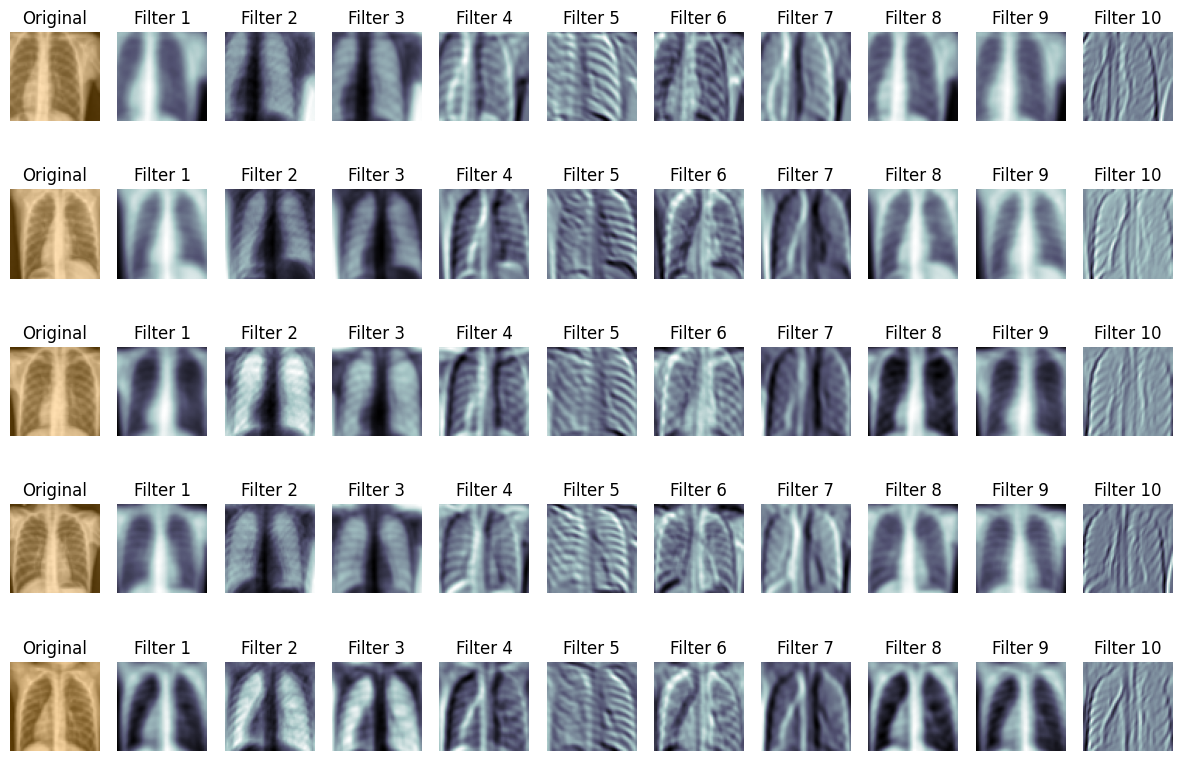

In [183]:
N_IMAGES = 5
N_FILTERS = 10

images = [image for image, label in [train_ds[i] for i in range(N_IMAGES)]]
filters = ResNet152_model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

The leftmost column of the plot shows the original input image, and the subsequent columns show the filtered output for each filter applied to the image.

By visually inspecting the filtered outputs, one can get an idea of what features of the image are being captured by each filter. If a filter consistently highlights a certain feature in different input images, it may indicate that the filter is specialized in detecting that feature.

In summary, the code allows for visualizing the output of convolutional filters on a set of input images, which can help in understanding what features a pre-trained model is detecting.

In [184]:
AnotiNet_model

AnotiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12544, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)

### RexNet101 Model Evaluation

In [185]:
ResNet101_model.load_state_dict(torch.load('best-ResNet101_model.pt'))

<All keys matched successfully>

In [186]:
images, labels, probs = get_predictions(ResNet101_model, test_iter)

In [187]:
test = pd.read_csv('/content/drive/MyDrive/pneumonia_dataset/pneumonia_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

In [188]:
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)


disp = classification_report(true_class, pred_class)
print(disp)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        68
           1       0.96      0.99      0.97       353

    accuracy                           0.96       421
   macro avg       0.94      0.90      0.92       421
weighted avg       0.96      0.96      0.96       421



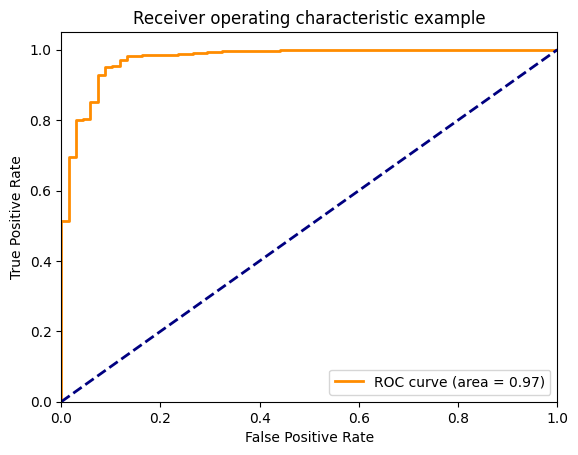

<ipython-input-189-0043c8c77eeb>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


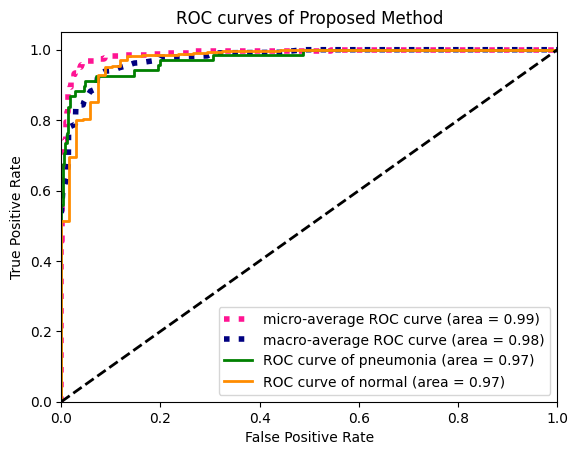

In [189]:
n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of pneumonia (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of normal (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[ 55  13]
 [  5 348]]
[ 68 353]
[[ 68.  68.]
 [353. 353.]]


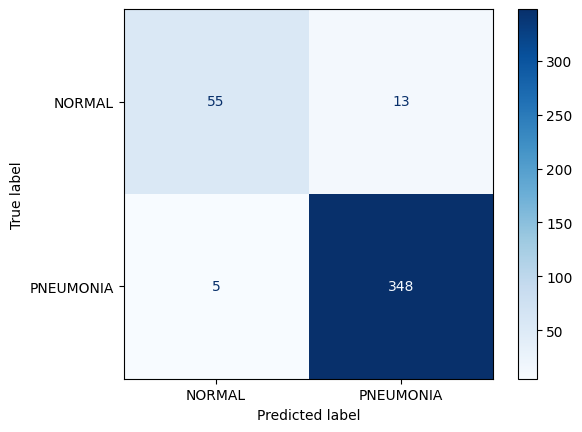

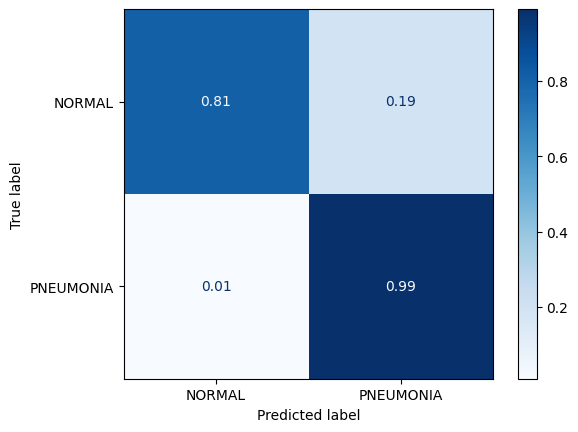

In [190]:
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
class_names = ["NORMAL", "PNEUMONIA"]

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 68
divisor[1][:] = 353
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

### AlexNet Model Evaluation

In [191]:
AlexNet_model.load_state_dict(torch.load('best-AlexNet_model.pt'))

<All keys matched successfully>

In [192]:
images, labels, probs = get_predictions(AlexNet_model, test_iter)

In [193]:
test = pd.read_csv('/content/drive/MyDrive/pneumonia_dataset/pneumonia_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

In [194]:
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)


disp = classification_report(true_class, pred_class)
print(disp)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        68
           1       0.96      0.97      0.97       353

    accuracy                           0.95       421
   macro avg       0.91      0.89      0.90       421
weighted avg       0.95      0.95      0.95       421



[[ 55  13]
 [  9 344]]
[ 68 353]
[[ 68.  68.]
 [353. 353.]]


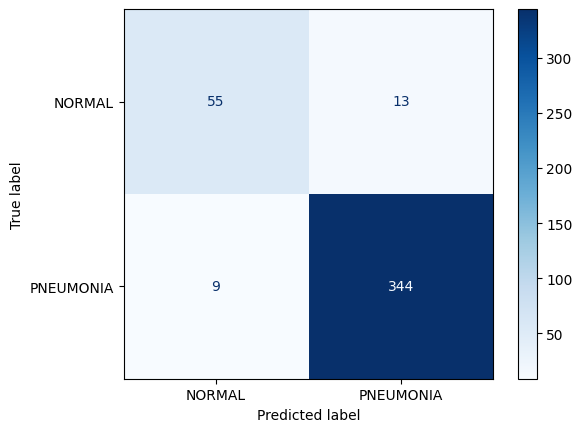

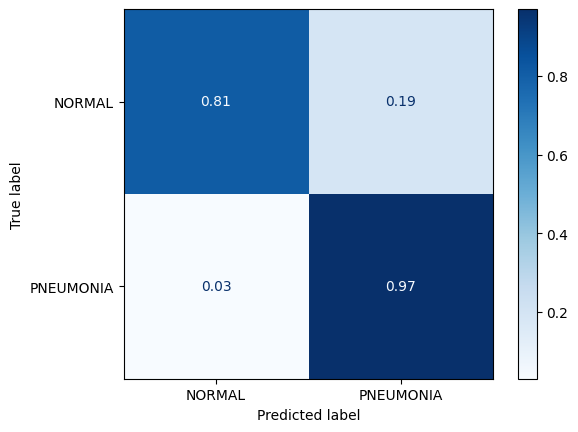

In [195]:
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
class_names = ["NORMAL", "PNEUMONIA"]

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 68
divisor[1][:] = 353
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

### AnotiNet Model Evaluation

In [196]:
AnotiNet_model.load_state_dict(torch.load('best-AnotiNet_model.pt'))

<All keys matched successfully>

In [197]:
images, labels, probs = get_predictions_new(AnotiNet_model, test_iter)

In [198]:
test = pd.read_csv('/content/drive/MyDrive/pneumonia_dataset/pneumonia_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

In [199]:
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)


disp = classification_report(true_class, pred_class)
print(disp)

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        68
           1       0.95      0.98      0.97       353

    accuracy                           0.94       421
   macro avg       0.91      0.86      0.88       421
weighted avg       0.94      0.94      0.94       421



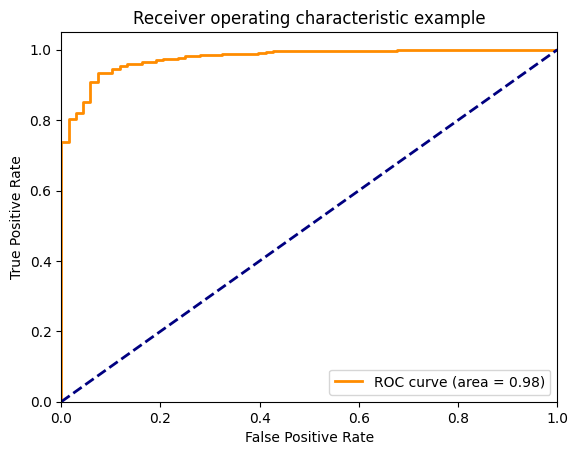

<ipython-input-200-0043c8c77eeb>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


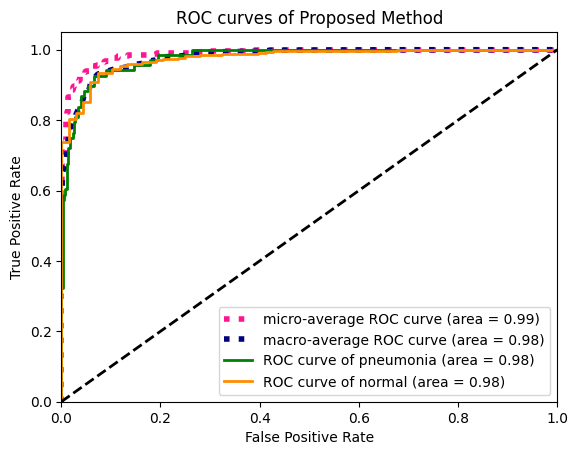

In [200]:
n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of pneumonia (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of normal (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[ 51  17]
 [  8 345]]
[ 68 353]
[[ 68.  68.]
 [353. 353.]]


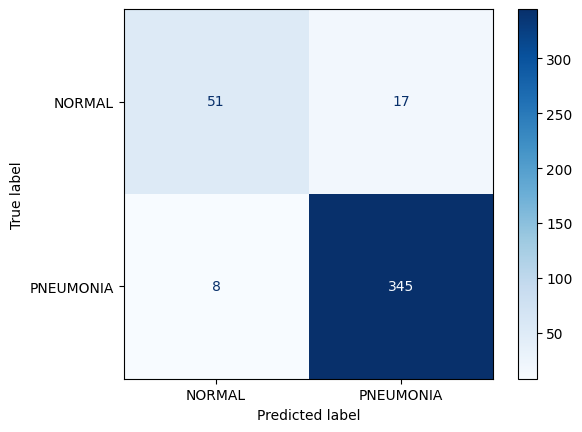

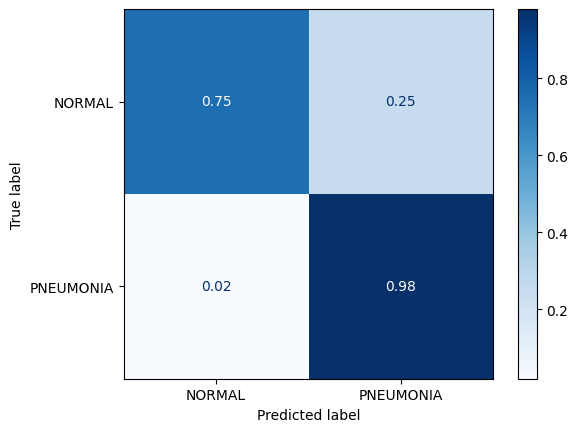

In [201]:
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
class_names = ["NORMAL", "PNEUMONIA"]

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 68
divisor[1][:] = 353
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [202]:
import pandas as pd

# Define the model architecture
class AnotiNet(nn.Module):
    def __init__(self):
        super(AnotiNet, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.25)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.20)
        self.batch2 = nn.BatchNorm2d(64)
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 14 * 14, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=2)

    def forward(self, x):
        # Pass input through first Convolutional Layer and Pooling Layer
        x = self.pool1(F.relu(self.batch1(self.drop1(self.conv1(x)))))
        # Pass input through second Convolutional Layer and Pooling Layer
        x = self.pool2(F.relu(self.batch2(self.drop2(self.conv2(x)))))
        # Flatten the output from the Pooling Layer
        x = x.view(x.size(0), -1)
        # Pass the flattened output through the first Fully Connected Layer
        x = F.relu(self.fc1(x))
        # Pass the output from the first Fully Connected Layer through the second Fully Connected Layer
        x = self.fc2(x)
        return x

# Create an instance of the AnotiNet model
AnotiNet_model = AnotiNet()

# Create a table to store the layer information
table_data = []

# Iterate over the model's named parameters
for name, param in AnotiNet_model.named_parameters():
    if len(param.shape) > 0:  # Exclude non-trainable parameters
        output_shape = tuple(param.shape)
        num_params = param.numel()
        table_data.append([name, output_shape, num_params])

# Create a pandas DataFrame from the table data
table_df = pd.DataFrame(table_data, columns=['Layer', 'Output Shape', 'Parameters'])

# Print the table
print(table_df)


            Layer    Output Shape  Parameters
0    conv1.weight   (32, 3, 3, 3)         864
1      conv1.bias           (32,)          32
2   batch1.weight           (32,)          32
3     batch1.bias           (32,)          32
4    conv2.weight  (64, 32, 3, 3)       18432
5      conv2.bias           (64,)          64
6   batch2.weight           (64,)          64
7     batch2.bias           (64,)          64
8      fc1.weight     (30, 12544)      376320
9        fc1.bias           (30,)          30
10     fc2.weight         (2, 30)          60
11       fc2.bias            (2,)           2
